In [1]:
%load_ext autoreload
%autoreload 2
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import TABLEAU_COLORS, CSS4_COLORS
from tqdm.auto import tqdm
import seaborn as sns
from pathlib import Path
import cv2
import matplotlib as mpl
import os
if Path('.').resolve().name != 'Arena':
    os.chdir('../Arena')
from db_models import ORM, Experiment, Strike, Block, Video, Trial
from analysis.pose_utils import plot_regression, colorline
from analysis.strikes.strikes import Loader, StrikeAnalyzer

In [2]:
orm = ORM()

In [10]:
def load_data(is_hits_only=True):
    filters = [
        Experiment.arena.in_(['reptilearn4', 'msi-regev']),
        Experiment.animal_id.startswith('PV'),
        Experiment.start_time > '2023-04-18',
    ]
    if is_hits_only:
        filters.append(Strike.is_hit)
    with orm.session() as s:
        orm_res = s.query(Strike, Block, Experiment).join(Block, Block.id == Strike.block_id).join(Experiment, Experiment.id == Block.experiment_id).filter(*filters).all()
        df_ = []
        for strk, blk, exp in tqdm(orm_res):
            video_path = None
            vids = [v for v in blk.videos if v.cam_name == 'front']
            if len(vids) == 1:
                video_path = vids[0].path

            ld = Loader(int(strk.id), 'front', orm=orm, sec_before=0, sec_after=30, is_debug=False)
            predicted_percent = (~ld.frames_df.nose.cam_x.isna()).sum() / len(ld.frames_df)

            df_.append({'strike_id': strk.id, 'animal_id': exp.animal_id, 'video': video_path,
                        'predicted_percent': predicted_percent})
    return pd.DataFrame(df_)

df = load_data()
df

,strike_id,animal_id,video
0,10,PV144,/data/Pogona_Pursuit/output/experiments/PV144/...
1,13,PV144,/data/Pogona_Pursuit/output/experiments/PV144/...
2,15,PV144,/data/Pogona_Pursuit/output/experiments/PV144/...
3,16,PV144,/data/Pogona_Pursuit/output/experiments/PV144/...
4,19,PV119,/data/Pogona_Pursuit/output/experiments/PV119/...
...,...,...,...
961,2507,PV99,/data/Pogona_Pursuit/output/experiments/PV99/2...
962,2526,PV99,/data/Pogona_Pursuit/output/experiments/PV99/2...
963,2532,PV99,/data/Pogona_Pursuit/output/experiments/PV99/2...
964,2534,PV99,/data/Pogona_Pursuit/output/experiments/PV99/2...


<AxesSubplot:>

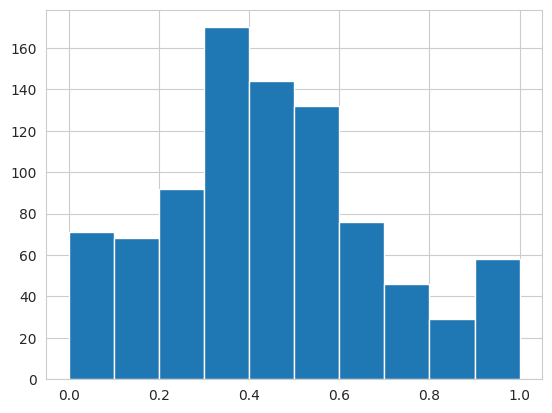

In [27]:
df.predicted_percent.hist()

(0, 10)